In [502]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow import keras

import scipy.stats as stats

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.2f}".format

sns.set_theme(style="darkgrid")
cm = px.colors.sequential.Bluered

warnings.filterwarnings("ignore")

In [503]:
# import sys

# sys.path.insert(1, '/kaggle/input/mymodules')

import my_module

In [504]:
# PATH = '/kaggle/input/house-prices-advanced-regression-techniques/'
PATH = ""

train = pd.read_csv(f"{PATH}train.csv")
train.drop(["Id"], axis=1, inplace=True)

test = pd.read_csv(f"{PATH}test.csv")
test_ID = test["Id"]

test.drop(["Id"], axis=1, inplace=True)

all_data = pd.concat([train, test], ignore_index=True)
df = all_data.copy(deep=True)

df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2914,160,RM,21.00,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,160,RM,21.00,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,20,RL,160.00,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,85,RL,62.00,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN
2918,60,RL,74.00,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,NaN


<a id='1'> </a>

# 1. EDA


Let's delete all columns with a lot of nan values


In [505]:
df = my_module.delete_nan_column(df, 0.25)

In [506]:
df["Train_test"] = df["SalePrice"].isnull().apply(lambda x: "Test" if x else "Train")

<a id='1.1'> </a>

## 1.1 Numeric columns


In [507]:
px.imshow(df.corr(), color_continuous_scale=cm, width=1000, height=1000)

First of all, I'm going to work with the features which are highly correlated with SalePrice.

Some of these features are correlated with each other, so I'm going to keep one of them and drop the other. For instance:

- YearBuilt and GarageYrBlt
- GarageArea and GarageCars


In [508]:
numeric_features = my_module.get_type_features(df, ["int64", "float64"])

df_corr_sorted = (
    df[numeric_features].corr().sort_values(by=["SalePrice"])[["SalePrice"]].T
)

px.imshow(df_corr_sorted, color_continuous_scale=cm)

In [509]:
features = my_module.get_corr_features(df[numeric_features].corr()["SalePrice"], 0.25)

Let's examine ditributions and try to find obvious outliers


In [510]:
for_plotting = [
    "OverallQual",
    "YearBuilt",
    "GrLivArea",
    "GarageArea",
    "1stFlrSF",
    "SalePrice",
]

# sns.pairplot(df[for_plotting + ["Train_test"]], diag_kind="kde", hue="Train_test")

There is a significant outlier. What else is important, that these features are skewed, so I'm going to transform it later to make it more normal.


In [511]:
df[df["1stFlrSF"] > 4500][features]

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice
1298,313.00,63887,10,2008,2008,796.00,5644.00,6110.00,4692,950,...,2,1,12,3,2008.00,2.00,1418.00,214,292,160000.00
2549,128.00,39290,10,2008,2009,1224.00,4010.00,5095.00,5095,0,...,2,1,15,2,2008.00,3.00,1154.00,546,484,NaN


1298 is the one. All positive correlated features are quite high, but the price is relatively low. I'll just delete it.


In [512]:
df.drop([1298], inplace=True)

<a></a>

### SalePrice


In [513]:
px.histogram(df, x="SalePrice").show()

In [514]:
df.loc[df["SalePrice"] > 480000, "SalePrice"] = 480000

In [515]:
px.histogram(df, x="SalePrice")

### YearBuilt/YearRemodAdd


I combined YearBuilt and YearRemodAdd in a column


In [516]:
df["YearBuilt/Remod"] = df["YearBuilt"].copy()
df.loc[df["YearBuilt"] > 1950, "YearBuilt/Remod"] = df.loc[
    df["YearBuilt"] > 1950, "YearRemodAdd"
]

In [517]:
px.histogram(df, x="YearBuilt/Remod", color="Train_test")

In [518]:
df.loc[df["YearBuilt/Remod"] < 1895, "YearBuilt/Remod"] = 1895
df.drop(["YearBuilt", "YearRemodAdd"], axis=1, inplace=True)
features.remove("YearBuilt")
features.remove("YearRemodAdd")
features.insert(0, "YearBuilt/Remod")

### GarageYrlBlt


In [519]:
px.histogram(df, x="GarageYrBlt", y="YearBuilt/Remod", color="Train_test")

In [520]:
px.scatter(df, x="GarageYrBlt", y="YearBuilt/Remod", color="Train_test")

In [521]:
df.loc[df["GarageYrBlt"] == 2207, "GarageYrBlt"] = 2007

In [522]:
px.scatter(df, x="GarageYrBlt", y="SalePrice")

In [523]:
df.loc[df["GarageYrBlt"].isnull(), "GarageYrBlt"] = df["YearBuilt/Remod"]

### GarageArea/GarageCars


In [524]:
df[["GarageArea", "GarageCars"]].corr()

,GarageArea,GarageCars
GarageArea,1.00,0.89
GarageCars,0.89,1.00


GarageArea looks more informative, so I delete GarageCars


In [525]:
df.drop(["GarageCars"], axis=1, inplace=True)
features.remove("GarageCars")

In [526]:
px.histogram(df, x="GarageArea", color="Train_test")

Some clipping


In [527]:
df.loc[df["GarageArea"] > 950, "GarageArea"] = 950

### TotalBsmtSF


In [528]:
px.histogram(df, x="TotalBsmtSF", color="Train_test")

In [529]:
df.loc[df["TotalBsmtSF"] > 2250, "TotalBsmtSF"] = 2250

<a id='1.1.2'> </a>

### GrLivArea


In [530]:
px.histogram(df, x="GrLivArea", color="Train_test")

In [531]:
df.loc[df["GrLivArea"] > 2900, "GrLivArea"] = 2900

### 1stFlrSF


In [532]:
px.histogram(df, x="1stFlrSF", color="Train_test")

In [533]:
df.loc[df["1stFlrSF"] > 2500, "1stFlrSF"] = 2500

### FullBath


In [534]:
px.histogram(df, x="FullBath", color="Train_test")

In [535]:
df.loc[df["FullBath"] == 0, "FullBath"] = 1
df.loc[df["FullBath"] == 4, "FullBath"] = 3
px.histogram(df, x="FullBath", color="Train_test")

### TotRmsAbvGrd


In [536]:
df[["TotRmsAbvGrd", "GrLivArea"]].corr()

,TotRmsAbvGrd,GrLivArea
TotRmsAbvGrd,1.00,0.81
GrLivArea,0.81,1.00


In [537]:
df.drop(["TotRmsAbvGrd"], axis=1, inplace=True)
features.remove("TotRmsAbvGrd")

### MasVnrArea


In [538]:
px.histogram(df, x="MasVnrArea", color="Train_test")

In [539]:
px.scatter(df[df["MasVnrArea"] > 0], x="MasVnrArea", y="SalePrice")

In [540]:
df.drop(["MasVnrArea"], axis=1, inplace=True)
features.remove("MasVnrArea")

### Fireplaces


In [541]:
px.histogram(df, x="Fireplaces", color="Train_test")

In [542]:
px.scatter(df, x="Fireplaces", y="SalePrice")

In [543]:
df.loc[df["Fireplaces"] > 2, "Fireplaces"] = 2

### BsmtFinSF1


In [544]:
px.histogram(df, x="BsmtFinSF1", color="Train_test")

In [545]:
for_dropping = "BsmtFinSF1"
df.drop([for_dropping], axis=1, inplace=True)
features.remove(for_dropping)

### LotFrontage


In [546]:
px.histogram(df, x="LotFrontage", color="Train_test")

In [547]:
px.scatter(df, x="LotFrontage", y="SalePrice")

In [548]:
df.loc[df["LotFrontage"] > 150, "LotFrontage"] = 150

### WoodDeckSF


In [549]:
px.histogram(df, x="WoodDeckSF", color="Train_test")

In [550]:
for_dropping = "WoodDeckSF"
df.drop([for_dropping], axis=1, inplace=True)
features.remove(for_dropping)

### 2ndFlrSF


In [551]:
px.histogram(df, x="2ndFlrSF", color="Train_test")

In [552]:
for_dropping = "2ndFlrSF"
df.drop([for_dropping], axis=1, inplace=True)
features.remove(for_dropping)

### OpenPorchSF


In [553]:
px.histogram(df, x="OpenPorchSF", color="Train_test")

In [554]:
for_dropping = "OpenPorchSF"
df.drop([for_dropping], axis=1, inplace=True)
features.remove(for_dropping)

### HalfBath


In [555]:
px.histogram(df, x="HalfBath", color="Train_test")

In [556]:
px.scatter(df, x="HalfBath", y="SalePrice")

In [557]:
df.loc[df["HalfBath"] == 2, "HalfBath"] = 1

### LotArea


In [558]:
fig = px.histogram(df, x="LotArea", color="Train_test")
fig.show()
px.scatter(df, x="LotArea", y="SalePrice")

In [559]:
df.drop(
    df.loc[(df["LotArea"] > 60000) & (~df["SalePrice"].isnull()), "LotArea"].index,
    inplace=True,
)

df.loc[(df["LotArea"] > 23000), "LotArea"] = 23000

<a id="2"></a>

# 2. Preprocessing


In [560]:
features

['YearBuilt/Remod',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'HalfBath',
 'Fireplaces',
 'GarageYrBlt',
 'GarageArea',
 'SalePrice']

In [561]:
df[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2913 entries, 0 to 2918
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YearBuilt/Remod  2913 non-null   int64  
 1   LotFrontage      2430 non-null   float64
 2   LotArea          2913 non-null   int64  
 3   OverallQual      2913 non-null   int64  
 4   TotalBsmtSF      2912 non-null   float64
 5   1stFlrSF         2913 non-null   int64  
 6   GrLivArea        2913 non-null   int64  
 7   FullBath         2913 non-null   int64  
 8   HalfBath         2913 non-null   int64  
 9   Fireplaces       2913 non-null   int64  
 10  GarageYrBlt      2913 non-null   float64
 11  GarageArea       2912 non-null   float64
 12  SalePrice        1454 non-null   float64
dtypes: float64(5), int64(8)
memory usage: 318.6 KB


Imput median values in the numeric columns


In [562]:
df_final = df[features].copy(deep=True)

### LotFrontage nans


In [563]:
df_lot = df_final[~df["LotFrontage"].isnull() & ~df["SalePrice"].isnull()]

lot_features = features.copy()
lot_features.remove("LotFrontage")
lot_features.remove("SalePrice")
x_lot = df_lot[lot_features]
y_lot = df_lot["LotFrontage"]

x_train, x_test, y_train, y_test = train_test_split(
    x_lot, y_lot, test_size=0.2, random_state=1
)

In [564]:
my_module.check_distribution(x_train, x_test)

,YearBuilt/Remod,LotArea,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,HalfBath,Fireplaces,GarageYrBlt,GarageArea
0,True,True,True,True,True,True,True,True,True,True,True


In [565]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ShuffleSplit

scaler = preprocessing.StandardScaler()

pipe = Pipeline(steps=[("scaler", scaler), ("KN", KNeighborsRegressor())])

grid = {
    "KN__weights": ["uniform", "distance"],
    "KN__n_neighbors": [n for n in np.arange(5, 20, 2)],
    "KN__p": [1, 2],
}

clf = GridSearchCV(pipe, grid, cv=ShuffleSplit(n_splits=5, random_state=1))

clf.fit(x_train, y_train)
model_k = clf.best_estimator_
y_predict = model_k.predict(x_test)
my_module.print_evaluate_regression(y_test, y_predict)
model_k

MSE: 223.5328865263853
RMSLE: 0.043277759742117526
______


Pipeline(steps=[('scaler', StandardScaler()),
                ('KN',
                 KNeighborsRegressor(n_neighbors=19, weights='distance'))])

In [566]:
for col in features[:-1]:
    imp = SimpleImputer(missing_values=np.nan, strategy="median")
    df_final[[col]] = imp.fit_transform(df_final[[col]])

### Transform the features


In [567]:
power = preprocessing.PowerTransformer(standardize=False)
for_tranfrom = [
    "TotalBsmtSF",
    "1stFlrSF",
    "GrLivArea",
    "GarageArea",
    "LotFrontage",
    "LotArea",
]
df_final[for_tranfrom] = power.fit_transform(df_final[for_tranfrom])
df_final.head()

,YearBuilt/Remod,LotFrontage,LotArea,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,HalfBath,Fireplaces,GarageYrBlt,GarageArea,SalePrice
0,2003.00,28.63,398.47,7.00,320.00,7.39,11.70,2.00,1.00,0.00,2003.00,231.38,208500.00
1,1976.00,33.53,430.71,6.00,441.37,7.86,11.01,2.00,0.00,1.00,1976.00,199.80,181500.00
2,2002.00,29.63,474.44,7.00,339.70,7.48,11.80,2.00,1.00,1.00,2001.00,252.43,223500.00
3,1915.00,26.93,429.34,7.00,288.70,7.53,11.71,1.00,0.00,1.00,1998.00,264.20,140000.00
4,2000.00,34.79,548.20,8.00,407.20,7.74,12.30,2.00,1.00,1.00,2000.00,329.59,250000.00


Scalling


In [568]:
scaler = preprocessing.StandardScaler()
df_final[df_final.columns[:-1]] = scaler.fit_transform(df_final.iloc[:, :-1])
df_final.head()

,YearBuilt/Remod,LotFrontage,LotArea,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,HalfBath,Fireplaces,GarageYrBlt,GarageArea,SalePrice
0,0.92,-0.15,-0.24,0.65,-0.41,-0.78,0.57,0.80,1.30,-0.94,1.00,0.40,208500.00
1,0.05,0.58,0.06,-0.06,0.54,0.43,-0.38,0.80,-0.77,0.65,-0.01,-0.00,181500.00
2,0.89,-0.00,0.45,0.65,-0.26,-0.56,0.71,0.80,1.30,0.65,0.93,0.67,223500.00
3,-1.91,-0.41,0.04,0.65,-0.66,-0.42,0.58,-1.05,-0.77,0.65,0.81,0.82,140000.00
4,0.83,0.77,1.13,1.36,0.27,0.13,1.38,0.80,1.30,0.65,0.89,1.65,250000.00


<a id="3"></a>

# 3. Model development


<a id='3.1'> </a>

## 3.1 Baseline


In [569]:
df_final.columns

Index(['YearBuilt/Remod', 'LotFrontage', 'LotArea', 'OverallQual',
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'HalfBath',
       'Fireplaces', 'GarageYrBlt', 'GarageArea', 'SalePrice'],
      dtype='object')

Selected features after testing


In [570]:
for_prediction = [
    "OverallQual",
    "TotalBsmtSF",
    "GrLivArea",
    "GarageArea",
    "1stFlrSF",
    "YearBuilt/Remod",
    # "FullBath",
    "LotArea",
    # 'GarageYrBlt',
    "Fireplaces",
    # 'LotFrontage',
    "SalePrice",
]

df_features = df_final[for_prediction]

In [571]:
rng = 1
x = df_features[~df_features["SalePrice"].isna()][df_features.columns[:-1]]
y = df_features[~df_features["SalePrice"].isna()]["SalePrice"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=rng
)

In [572]:
my_module.check_distribution(x_train, x_test)

,OverallQual,TotalBsmtSF,GrLivArea,GarageArea,1stFlrSF,YearBuilt/Remod,LotArea,Fireplaces
0,True,True,True,True,True,True,True,True


As we predict a continues value, we can use a mean value as a baseline


In [573]:
mean_price = np.full(len(x), np.mean(y))
my_module.print_evaluate_regression(mean_price, y)

MSE: 5660375464.688142
RMSLE: 0.16172772987404516
______


<a id='3.2'></a>

## 3.2 Simple NN model


In [574]:
x_train.head()

,OverallQual,TotalBsmtSF,GrLivArea,GarageArea,1stFlrSF,YearBuilt/Remod,LotArea,Fireplaces
1153,-0.06,-0.51,-1.70,-0.13,-0.93,-1.43,-0.95,-0.94
601,-0.06,-0.60,-0.12,0.38,-1.07,-1.20,-0.09,0.65
215,-0.77,0.10,-0.45,-0.06,0.37,0.70,0.16,0.65
135,0.65,0.64,0.52,0.32,1.34,-0.14,0.25,0.65
818,-0.06,-0.04,-0.94,-0.09,-0.14,-0.11,-0.14,-0.94


Final training loss: 794180032.0
Final Validation loss: 618339584.0
10/10 [==============================] - 0s 1ms/step
MSE: 662525929.1022725
RMSLE: 0.026005591699653625
______


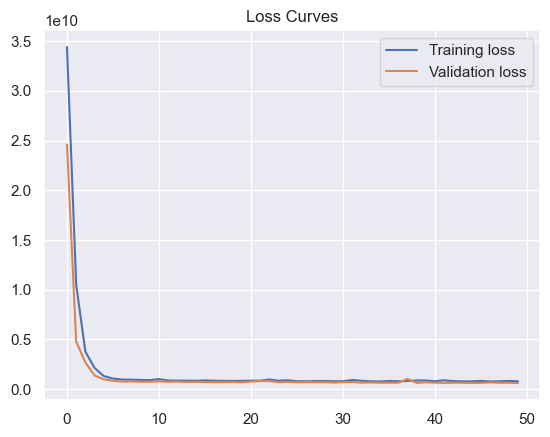

In [226]:
learning_rate = 0.5
epochs = 50
batch_size = 50

model = None

# Define model
model = keras.Sequential()
model.add(
    keras.layers.Dense(
        units=x_train.shape[1],
        activation="relu",
        input_dim=x_train.shape[1],
        kernel_regularizer=tf.keras.regularizers.l2(l2=0.01),
    ),
)
model.add(
    keras.layers.Dense(
        units=x_train.shape[1],
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(l2=0.01),
    )
)

model.add(keras.layers.Dense(units=1, activation="linear"))
# Specify the optimizer using the TF API to specify the learning rate
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.MeanSquaredError(),
)

# Train the model
trainHistory = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=0,
)
# Plot
my_module.showRegressionResults(trainHistory)


my_module.print_evaluate_regression(y_test, model.predict(x_test))

In [221]:
import logging

logname = "model_results.log"

logging.basicConfig(
    filename=logname,
    filemode="a",
    format="%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s",
    datefmt="%H:%M:%S",
    level=logging.INFO,
)

logger = logging.getLogger("my_logger")

logging.info("Logging set")
logging.info(model.to_json())
logging.info(for_prediction[:-1])
my_module.log_evaluate_regression(model.predict(x_test), y_test)
logging.shutdown()

10/10 [==============================] - 0s 1ms/step


In [222]:
x_sub = df_final.loc[df["SalePrice"].isna()][for_prediction[:-1]]
pred = model.predict(x_sub, batch_size=batch_size).flatten()

sub = pd.DataFrame({"Id": test_ID, "SalePrice": pred})
my_module.test_nulls(sub)
sub.to_csv("submission.csv", index=False)

30/30 [==============================] - 0s 1ms/step
Engineered features do not contain nulls.


In [576]:
all_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [582]:
# all_data.columns
# cols = ['GarageArea', 'TotalBsmtSF', 'MasVnrArea', 'BsmtFinSF1', 'WoodDeckSF',
#         '2ndFlrSF', 'OpenPorchSF']
# res = set(all_data['MasVnrArea'].to_numpy())
# for col in cols:
#     res = res.intersection(all_data[col].index.to_numpy())
# all_data.loc[res]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.00
1,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.00
3,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.00
11,60,RL,85.00,11924,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2006,New,Partial,345000.00
14,20,RL,NaN,10920,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,GdWo,NaN,0,5,2008,WD,Normal,157000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170,80,RL,76.00,9880,Pave,NaN,Reg,Lvl,AllPub,Inside,...,576,Gd,GdPrv,NaN,0,7,2008,WD,Normal,171000.00
1224,60,RL,60.00,15384,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,184000.00
1290,80,RL,NaN,14112,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,180500.00
1378,160,RM,21.00,1953,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,83000.00
